Processing round2 files in R3: 100%|██████████| 10/10 [00:01<00:00,  7.03it/s]


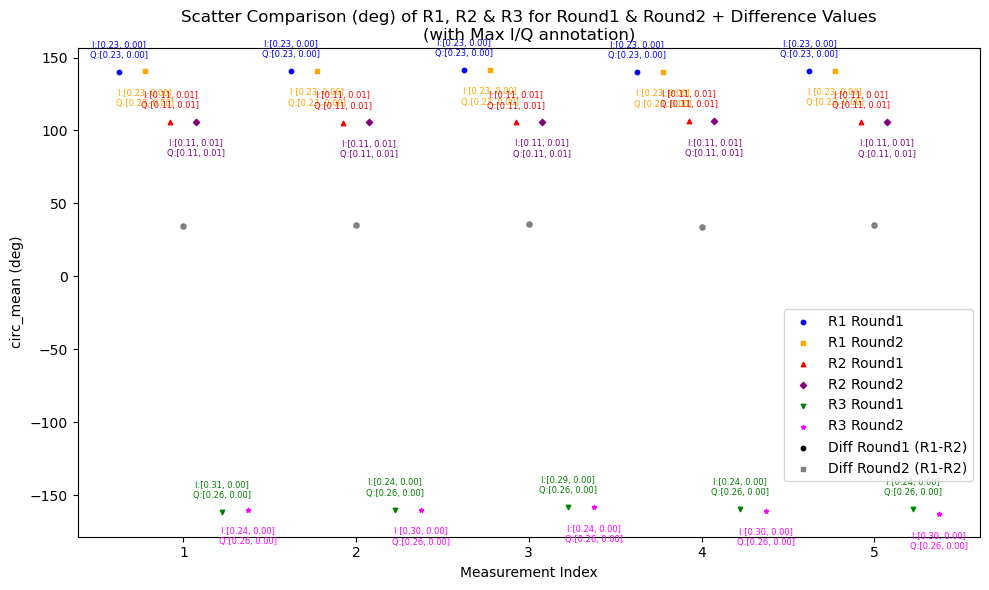

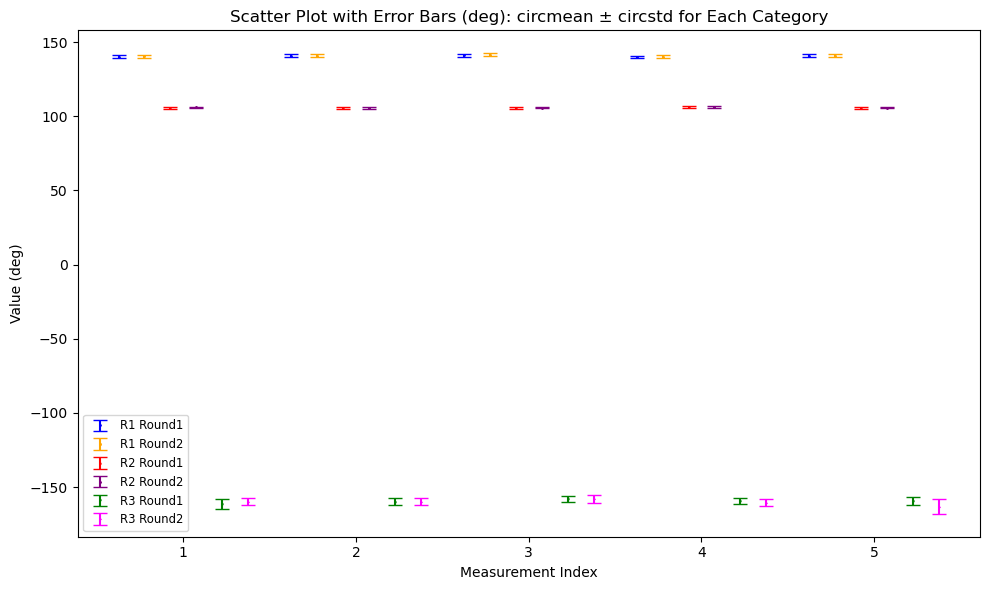

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Button
import tools
from tqdm import tqdm

def parse_timestamp(filename, round_tag):
    if round_tag not in filename:
        return None
    parts = filename.split(round_tag + "_")
    if len(parts) < 2:
        return None
    timestamp_str = parts[1].replace(".npy", "")
    if not timestamp_str:
        return None
    return timestamp_str

def compute_circ_stats(iq_samples):
    phase_ch0, _ = tools.get_phases_and_apply_bandpass(iq_samples[0, :], deg=True)
    phase_ch1, _ = tools.get_phases_and_apply_bandpass(iq_samples[1, :], deg=True)
    phase_diff = tools.to_min_pi_plus_pi(phase_ch0 - phase_ch1, deg=True)
    circ_mean_val = tools.circmean(phase_diff, deg=True)
    circ_std_val = tools.circstd(phase_diff, deg=True)
    return circ_mean_val, circ_std_val

def get_max_IQ(iq_samples):
    max_I = np.max(np.abs(np.real(iq_samples)), axis=1)
    max_Q = np.max(np.abs(np.imag(iq_samples)), axis=1)
    return max_I, max_Q

def get_sorted_stats(folder_path, round_tag):
    results = []
    files = os.listdir(folder_path)
    for filename in tqdm(files, desc=f"Processing {round_tag} files in {os.path.basename(folder_path)}"):
        if filename.endswith(".npy") and round_tag in filename:
            full_path = os.path.join(folder_path, filename)
            timestamp_str = parse_timestamp(filename, round_tag)
            if not timestamp_str:
                continue
            try:
                iq_samples = np.load(full_path)
                circ_mean_val, circ_std_val = compute_circ_stats(iq_samples)
                max_I, max_Q = get_max_IQ(iq_samples)
                results.append((timestamp_str, circ_mean_val, circ_std_val, max_I, max_Q))
            except Exception as e:
                print(f"处理文件 {filename} 出错: {e}")
    results.sort(key=lambda x: x[0])
    return results

def main():
    current_dir = os.getcwd()
    r1_dir = os.path.join(current_dir, "R1")
    r2_dir = os.path.join(current_dir, "R2")
    r3_dir = os.path.join(current_dir, "R3")  # 新增 R3 文件夹

    r1_round1_stats = get_sorted_stats(r1_dir, "round1")
    r1_round2_stats = get_sorted_stats(r1_dir, "round2")
    r2_round1_stats = get_sorted_stats(r2_dir, "round1")
    r2_round2_stats = get_sorted_stats(r2_dir, "round2")
    r3_round1_stats = get_sorted_stats(r3_dir, "round1")  # R3 round1
    r3_round2_stats = get_sorted_stats(r3_dir, "round2")  # R3 round2

    min_len = min(len(r1_round1_stats), len(r1_round2_stats),
                  len(r2_round1_stats), len(r2_round2_stats),
                  len(r3_round1_stats), len(r3_round2_stats))
    if min_len == 0:
        print("无法绘制：至少一组数据为空或无法匹配。")
        return

    # 提取各类别的 circmean
    r1_round1_vals = [r1_round1_stats[i][1] for i in range(min_len)]
    r1_round2_vals = [r1_round2_stats[i][1] for i in range(min_len)]
    r2_round1_vals = [r2_round1_stats[i][1] for i in range(min_len)]
    r2_round2_vals = [r2_round2_stats[i][1] for i in range(min_len)]
    r3_round1_vals = [r3_round1_stats[i][1] for i in range(min_len)]
    r3_round2_vals = [r3_round2_stats[i][1] for i in range(min_len)]

    # 提取各类别的 max_I 与 max_Q 用于标注
    r1_round1_maxI = [r1_round1_stats[i][3] for i in range(min_len)]
    r1_round1_maxQ = [r1_round1_stats[i][4] for i in range(min_len)]
    r1_round2_maxI = [r1_round2_stats[i][3] for i in range(min_len)]
    r1_round2_maxQ = [r1_round2_stats[i][4] for i in range(min_len)]
    r2_round1_maxI = [r2_round1_stats[i][3] for i in range(min_len)]
    r2_round1_maxQ = [r2_round1_stats[i][4] for i in range(min_len)]
    r2_round2_maxI = [r2_round2_stats[i][3] for i in range(min_len)]
    r2_round2_maxQ = [r2_round2_stats[i][4] for i in range(min_len)]
    r3_round1_maxI = [r3_round1_stats[i][3] for i in range(min_len)]
    r3_round1_maxQ = [r3_round1_stats[i][4] for i in range(min_len)]
    r3_round2_maxI = [r3_round2_stats[i][3] for i in range(min_len)]
    r3_round2_maxQ = [r3_round2_stats[i][4] for i in range(min_len)]

    x = np.arange(1, min_len + 1)
    offset = 0.15
    # 为每组数据定义不同的 x 轴偏移位置（每个测量点分布 6 个位置）
    x_r1_r1 = x - 2.5 * offset
    x_r1_r2 = x - 1.5 * offset
    x_r2_r1 = x - 0.5 * offset
    x_r2_r2 = x + 0.5 * offset
    x_r3_r1 = x + 1.5 * offset
    x_r3_r2 = x + 2.5 * offset

    fig, ax = plt.subplots(figsize=(10, 6))
    # 绘制散点图：circmean (deg)
    ax.scatter(x_r1_r1, r1_round1_vals, marker='o', s=10, color='blue', label='R1 Round1')
    ax.scatter(x_r1_r2, r1_round2_vals, marker='s', s=10, color='orange', label='R1 Round2')
    ax.scatter(x_r2_r1, r2_round1_vals, marker='^', s=10, color='red', label='R2 Round1')
    ax.scatter(x_r2_r2, r2_round2_vals, marker='D', s=10, color='purple', label='R2 Round2')
    ax.scatter(x_r3_r1, r3_round1_vals, marker='v', s=10, color='green', label='R3 Round1')
    ax.scatter(x_r3_r2, r3_round2_vals, marker='*', s=10, color='magenta', label='R3 Round2')

    # 差值散点（保持原有 R1 与 R2 的差值）
    diff_round1 = [r1_round1_vals[i] - r2_round1_vals[i] for i in range(min_len)]
    diff_round2 = [r1_round2_vals[i] - r2_round2_vals[i] for i in range(min_len)]
    ax.scatter(x, diff_round1, marker='o', color='black', s=10, label='Diff Round1 (R1-R2)')
    ax.scatter(x, diff_round2, marker='s', color='gray', s=10, label='Diff Round2 (R1-R2)')

    # 为每个数据点标注 max_I 与 max_Q
    for i in range(min_len):
        # -- R1 Round1 上方 --
        ax.annotate(
            f"I:[{r1_round1_maxI[i][0]:.2f}, {r1_round1_maxI[i][1]:.2f}]\n"
            f"Q:[{r1_round1_maxQ[i][0]:.2f}, {r1_round1_maxQ[i][1]:.2f}]",
            (x_r1_r1[i], r1_round1_vals[i]), textcoords="offset points", xytext=(0, 10),
            ha='center', fontsize=6, color='blue'
        )
        # -- R1 Round2 下方 --
        ax.annotate(
            f"I:[{r1_round2_maxI[i][0]:.2f}, {r1_round2_maxI[i][1]:.2f}]\n"
            f"Q:[{r1_round2_maxQ[i][0]:.2f}, {r1_round2_maxQ[i][1]:.2f}]",
            (x_r1_r2[i], r1_round2_vals[i]), textcoords="offset points", xytext=(0, -25),
            ha='center', fontsize=6, color='orange'
        )
        # -- R2 Round1 上方 --
        ax.annotate(
            f"I:[{r2_round1_maxI[i][0]:.2f}, {r2_round1_maxI[i][1]:.2f}]\n"
            f"Q:[{r2_round1_maxQ[i][0]:.2f}, {r2_round1_maxQ[i][1]:.2f}]",
            (x_r2_r1[i], r2_round1_vals[i]), textcoords="offset points", xytext=(0, 10),
            ha='center', fontsize=6, color='red'
        )
        # -- R2 Round2 下方 --
        ax.annotate(
            f"I:[{r2_round2_maxI[i][0]:.2f}, {r2_round2_maxI[i][1]:.2f}]\n"
            f"Q:[{r2_round2_maxQ[i][0]:.2f}, {r2_round2_maxQ[i][1]:.2f}]",
            (x_r2_r2[i], r2_round2_vals[i]), textcoords="offset points", xytext=(0, -25),
            ha='center', fontsize=6, color='purple'
        )
        # -- R3 Round1 上方 --
        ax.annotate(
            f"I:[{r3_round1_maxI[i][0]:.2f}, {r3_round1_maxI[i][1]:.2f}]\n"
            f"Q:[{r3_round1_maxQ[i][0]:.2f}, {r3_round1_maxQ[i][1]:.2f}]",
            (x_r3_r1[i], r3_round1_vals[i]), textcoords="offset points", xytext=(0, 10),
            ha='center', fontsize=6, color='green'
        )
        # -- R3 Round2 下方 --
        ax.annotate(
            f"I:[{r3_round2_maxI[i][0]:.2f}, {r3_round2_maxI[i][1]:.2f}]\n"
            f"Q:[{r3_round2_maxQ[i][0]:.2f}, {r3_round2_maxQ[i][1]:.2f}]",
            (x_r3_r2[i], r3_round2_vals[i]), textcoords="offset points", xytext=(0, -25),
            ha='center', fontsize=6, color='magenta'
        )

    ax.set_xticks(x)
    ax.set_xticklabels([str(i) for i in x])
    ax.set_xlabel('Measurement Index')
    ax.set_ylabel('circ_mean (deg)')
    ax.set_title('Scatter Comparison (deg) of R1, R2 & R3 for Round1 & Round2 + Difference Values\n(with Max I/Q annotation)')
    ax.legend(loc='lower right', bbox_to_anchor=(1, 0.1))
    plt.tight_layout()
    plt.show()

    # 第二部分：误差棒散点图
    r1_r1_means = r1_round1_vals
    r1_r1_stds  = [r1_round1_stats[i][2] for i in range(min_len)]
    r1_r2_means = r1_round2_vals
    r1_r2_stds  = [r1_round2_stats[i][2] for i in range(min_len)]
    r2_r1_means = r2_round1_vals
    r2_r1_stds  = [r2_round1_stats[i][2] for i in range(min_len)]
    r2_r2_means = r2_round2_vals
    r2_r2_stds  = [r2_round2_stats[i][2] for i in range(min_len)]
    r3_r1_means = r3_round1_vals
    r3_r1_stds  = [r3_round1_stats[i][2] for i in range(min_len)]
    r3_r2_means = r3_round2_vals
    r3_r2_stds  = [r3_round2_stats[i][2] for i in range(min_len)]

    fig2, ax2 = plt.subplots(figsize=(10, 6))
    ax2.errorbar(x_r1_r1, r1_r1_means, yerr=r1_r1_stds, fmt='o', ms=1, color='blue', capsize=5, label='R1 Round1')
    ax2.errorbar(x_r1_r2, r1_r2_means, yerr=r1_r2_stds, fmt='s', ms=1, color='orange', capsize=5, label='R1 Round2')
    ax2.errorbar(x_r2_r1, r2_r1_means, yerr=r2_r1_stds, fmt='^', ms=1, color='red', capsize=5, label='R2 Round1')
    ax2.errorbar(x_r2_r2, r2_r2_means, yerr=r2_r2_stds, fmt='D', ms=1, color='purple', capsize=5, label='R2 Round2')
    ax2.errorbar(x_r3_r1, r3_r1_means, yerr=r3_r1_stds, fmt='v', ms=1, color='green', capsize=5, label='R3 Round1')
    ax2.errorbar(x_r3_r2, r3_r2_means, yerr=r3_r2_stds, fmt='*', ms=1, color='magenta', capsize=5, label='R3 Round2')

    ax2.set_xticks(x)
    ax2.set_xticklabels([str(i) for i in x])
    ax2.set_xlabel('Measurement Index')
    ax2.set_ylabel('Value (deg)')
    ax2.set_title('Scatter Plot with Error Bars (deg): circmean ± circstd for Each Category')
    ax2.legend(loc='best', fontsize='small')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


In [22]:
import numpy as np

def read_npy_file(file_path):
    """
    Read a .npy file and print its content
    :param file_path: Path to the .npy file
    """
    try:
        data = np.load(file_path, allow_pickle=True)
        print("Shape of the array:", data.shape)
        print("Data type of the array:", data.dtype)

        if data.ndim == 0:
            print("The array is 0-dimensional and contains a single object:")
            print(data.item())
        else:
            print("First row:", data[0])
            print("Second row:", data[1])
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")

if __name__ == "__main__":
    file_path = 'new_Htest.npy'  # Change to your .npy file path
    read_npy_file(file_path)

Shape of the array: (52, 33, 2)
Data type of the array: complex128
First row: [[-5.69744566e-03+1.31628554e-02j  1.19381902e-03+1.49132933e-02j]
 [-9.87843499e-03+2.87392871e-03j  6.11273251e-03+2.62112614e-03j]
 [-4.18209096e-03-2.47386260e-03j -8.01061095e-03+1.75667402e-02j]
 [-2.21989471e-02+1.93050332e-02j -1.51275053e-02-1.10355882e-02j]
 [-1.88764500e-03+1.12618985e-02j -4.43874238e-03+4.78233231e-05j]
 [ 2.73673673e-02-3.32820754e-03j  1.85442043e-02-3.08131442e-02j]
 [ 2.27265620e-02-2.18738252e-02j  1.14879707e-02-1.90724082e-02j]
 [ 2.63444889e-02+1.30921178e-03j -2.15106831e-03+9.43772279e-04j]
 [ 9.81898028e-05+2.54810886e-03j -1.09689145e-02-3.68636872e-02j]
 [-1.01815039e-02+6.33979612e-03j -2.63341209e-02-1.63065249e-02j]
 [ 1.36535002e-02-4.14907612e-03j -2.01080175e-03+4.65419986e-03j]
 [-1.77755272e-02+9.76886493e-03j -4.43523820e-05+1.43969317e-02j]
 [ 1.40851874e-02-1.77952387e-02j  8.74944706e-03+5.92347298e-03j]
 [-9.15797534e-03-1.00205844e-02j  1.13409678e-02+1

In [17]:
import numpy as np

def process_npy_file(file_path):
    """
    Read a .npy file and calculate the mean of each row
    :param file_path: Path to the .npy file
    """
    try:
        data = np.load(file_path)
        if data.ndim != 2:
            print(f"Invalid data shape: {data.shape}. Expected a 2D array.")
            return

        row_means = np.mean(data, axis=1)
        for i, mean in enumerate(row_means):
            print(f"Mean of row {i}: {mean}")

    except Exception as e:
        print(f"Error reading file {file_path}: {e}")

if __name__ == "__main__":
    file_path = 'round1_phase_data.npy'  # Change to your .npy file path
    process_npy_file(file_path)

Mean of row 0: (-0.19790387839462573+0.38672042924208344j)
Mean of row 1: (-0.35818609548648134+0.39663166744986306j)
Mean of row 2: (-0.2651385808423222+0.4300981565192804j)
Mean of row 3: (-0.36571167448691105+0.2465592765217783j)
Mean of row 4: (-0.3530736928227809+0.2865036080568858j)
Mean of row 5: (0.07514491588832721-0.24229571224871174j)
Mean of row 6: (0.11447702356059138-0.20601487811438715j)
Mean of row 7: (0.17432629764576268-0.26942562730329855j)
Mean of row 8: (-0.17391331316529776+0.10356461000092848j)
Mean of row 9: (-0.30101944927777724-0.0667237239931939j)
Mean of row 10: (-0.14477814177745452+0.13299916741739495j)
Mean of row 11: (-0.3650312559516337+0.20854733778870557j)
Mean of row 12: (-0.33786129368342743+0.12310532189344113j)
Mean of row 13: (-0.29317690055708034+0.2817381474785702j)
Mean of row 14: (-0.20740848298868395-0.3428067149096837j)
Mean of row 15: (0.07298912097375218-0.3665847736443666j)
Mean of row 16: (-0.02173578966078094-0.5122959153624939j)
Mean 

In [11]:
import numpy as np

def read_npy_file(file_path):
    """
    Read a .npy file and print its shape
    :param file_path: Path to the .npy file
    """
    try:
        data = np.load(file_path, allow_pickle=True)
        print("Shape of the array:", data.shape)
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")

if __name__ == "__main__":
    file_path = 'combined_amplitude_phase_data.npy'  # Change to your .npy file path
    read_npy_file(file_path)

Shape of the array: (33, 505)


In [ ]:
import os
import re
import math

def process_device_file(file_path):
    """
    处理单个设备文件：
      - 按照分隔符 '----------------------------------------' 拆分数据段；
      - 只提取包含 "round1" 的数据段；
      - 从数据段中提取时间戳（格式 round1_YYYYMMDD_HHMMSS）和 “CircMean phase diff” 数值；
      - 将 phase 数值转换为复数：实部为 cos(phase)，虚部为 sin(phase)；
      - 按时间戳排序后返回一个列表，每个元素为一个复数。
    """
    segments_data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()

    # 按照分隔符拆分数据段，并去除多余空白字符
    segments = [seg.strip() for seg in content.split('----------------------------------------') if seg.strip()]

    for seg in segments:
        # 只处理包含 "Processing file:" 的数据段
        if 'Processing file:' not in seg:
            continue

        # 提取 "Processing file:" 后面的文件名
        m_file = re.search(r'Processing file:\s*(\S+)', seg)
        if not m_file:
            continue
        filename = m_file.group(1)

        # 只处理文件名中包含 "round1" 的数据段
        if "round1" not in filename:
            continue

        # 从文件名中提取时间戳，格式假设为 round1_YYYYMMDD_HHMMSS
        m_ts = re.search(r'round1_(\d{8}_\d{6})', filename)
        if not m_ts:
            continue
        timestamp = m_ts.group(1)

        # 提取 “CircMean phase diff” 数值（单位为 rad）
        m_phase = re.search(r'CircMean phase diff:\s*([-+]?[0-9]*\.?[0-9]+)', seg)
        if not m_phase:
            continue
        try:
            phase_val = float(m_phase.group(1))
        except ValueError:
            continue

        # 计算复数：实部为 cos(phase)，虚部为 sin(phase)
        comp_value = complex(math.cos(phase_val), math.sin(phase_val))
        segments_data.append((timestamp, comp_value))

    # 根据时间戳排序（YYYYMMDD_HHMMSS 格式，直接字符串排序即可）
    segments_data.sort(key=lambda x: x[0])

    # 返回排序后的复数值列表
    return [comp for ts, comp in segments_data]

def main():
    data_folder = "Data"
    if not os.path.exists(data_folder):
        print(f"错误：目录 {data_folder} 不存在。")
        return

    # 遍历 Data 文件夹下所有 _result.txt 文件
    device_files = sorted([f for f in os.listdir(data_folder) if f.endswith("_result.txt")])

    for file_name in device_files:
        file_path = os.path.join(data_folder, file_name)
        measurements = process_device_file(file_path)
        # 提取设备名（假设文件名格式为 {设备名}_result.txt）
        device = file_name.split('_')[0]
        print(f"设备 {device} 的数据长度: {len(measurements)}")

if __name__ == "__main__":
    main()


In [15]:
import numpy as np

def combine_columns(file_path):
    # 加载信道数据，假设数据形状为 (M, N)，其中 M 行代表信道维度，N 列代表数据个数
    data = np.load(file_path)
    M, N = data.shape
    print(f"原始数据形状: {data.shape}")

    # 如果列数不是偶数，则舍去最后一列
    if N % 2 != 0:
        print("列数为奇数，舍去最后一列")
        data = data[:, :-1]
        N = data.shape[1]
        print(f"调整后数据形状: {data.shape}")

    num_pairs = N // 2
    combined_pairs = []

    # 对于每个配对，从第一列和最后一列开始依次组合
    for i in range(num_pairs):
        first_col = data[:, i]        # 第 i 列（从前面开始）
        last_col = data[:, -i-1]        # 对应的倒数第 i+1 列
        # 将两列组合成 (M, 2) 的矩阵
        pair = np.stack((first_col, last_col), axis=-1)
        combined_pairs.append(pair)

    # 将所有组合好的矩阵转为一个 (num_pairs, M, 2) 的数组
    combined_array = np.array(combined_pairs)
    return combined_array

if __name__ == "__main__":
    # 指定数据文件路径
    file_path = 'combined_amplitude_phase_data.npy'
    combined_data = combine_columns(file_path)
    print("组合后数据的形状:", combined_data.shape)
    # 保存组合后的数据（可选）
    np.save("combined_phase_data.npy", combined_data)


原始数据形状: (33, 505)
列数为奇数，舍去最后一列
调整后数据形状: (33, 504)
组合后数据的形状: (252, 33, 2)


In [19]:
import numpy as np

def concatenate_simulated_and_real(simulated_train_file, simulated_val_file, simulated_test_file, combined_data_file):
    # 加载模拟数据
    Htrain = np.load(simulated_train_file)
    Hval = np.load(simulated_val_file)
    Htest = np.load(simulated_test_file)

    # 加载真实数据（combined_phase_data.npy），要求其第一维至少为252
    combined_data = np.load(combined_data_file)
    total_real_samples = combined_data.shape[0]
    if total_real_samples < 252:
        raise ValueError(f"真实数据样本数不足252，当前样本数为 {total_real_samples}")

    # 将真实数据拆分为三部分：前100个、接下来的100个、最后52个
    combined_train = combined_data[:150]
    combined_val = combined_data[150:200]
    combined_test = combined_data[200:252]

    # # 拼接模拟数据与真实数据（在第一维上拼接）
    # new_Htrain = np.concatenate([Htrain, combined_train], axis=0)
    # new_Hval = np.concatenate([Hval, combined_val], axis=0)
    # new_Htest = np.concatenate([Htest, combined_test], axis=0)

    # 保存新的数据到新的文件（不覆盖原有文件）
    np.save("new_Htrain.npy", combined_train)
    np.save("new_Hval.npy", combined_val)
    np.save("new_Htest.npy", combined_test)

    # print("新的 new_Htrain.npy 形状:", new_Htrain.shape)
    # print("新的 new_Hval.npy 形状:", new_Hval.shape)
    # print("新的 new_Htest.npy 形状:", new_Htest.shape)

if __name__ == "__main__":
    simulated_train_file = "Htrain.npy"
    simulated_val_file = "Hval.npy"
    simulated_test_file = "Htest.npy"
    combined_data_file = "combined_phase_data.npy"

    concatenate_simulated_and_real(simulated_train_file, simulated_val_file, simulated_test_file, combined_data_file)


In [1]:
import pandas as pd

TRUE_LOCATION_PATH = "./location.xlsx"
true_locations_df = pd.read_excel(TRUE_LOCATION_PATH)

# 打印前几行数据，确认表头及数据是否正确
print("真实位置数据预览:")
print(true_locations_df.head())

# 打印所有 Z 轴数据
print("真实位置的 Z 轴数据:")
print(true_locations_df["z"].values)


真实位置数据预览:
      x     y     z
0  7526  1386  1270
1  7530  1501  1270
2  7542  1617  1270
3  7544  1717  1273
4  7549  1853  1280
真实位置的 Z 轴数据:
[1270 1270 1270 1273 1280 1281 1282 1278 1283 1285 1287 1283 1286 1285
 1285 1285 1284 1283 1282 1282 1282 1282 1281 1279 1278 1278 1277 1276
 1277 1277 1276 1274 1272 1272 1273 1273 1273 1274 1274 1272 1271 1275
 1274 1276 1276 1276 1276 1276 1276 1276 1277 1278 1279 1280 1280 1280
 1281 1284 1284 1285 1287 1288 1288 1289 1291 1292 1293 1293 1293 1290
 1289 1288 1287 1286 1284 1283 1283 1281 1280 1279 1279 1279 1278 1277
 1277 1276 1275 1274 1275 1276 1276 1276 1276 1276 1275 1276 1276 1277
 1276 1275 1275 1275 1276 1275 1276 1275 1275 1275 1276 1276 1278 1279
 1279 1278 1279 1281 1282 1283 1285 1286 1288 1290 1291 1292 1293 1292
 1291 1290 1288 1286 1285 1284 1282 1280 1279 1278 1278 1279 1278 1276
 1275 1276 1275 1275 1275 1275 1275 1275 1273 1276 1274 1275 1275 1275
 1275 1276 1276 1277 1277 1273 1274 1274 1275 1275 1275 1275 1275 1274
 1274

In [20]:
import numpy as np

def calculate_amplitude(file_path):
    """
    读取 .npy 文件并计算复数的振幅
    :param file_path: .npy 文件路径
    """
    try:
        # 加载数据
        data = np.load(file_path)

        # 检查数据是否为复数类型
        if not np.iscomplexobj(data):
            print("数据不包含复数，无法计算振幅。")
            return

        # 计算振幅
        amplitudes = np.abs(data)
        print("振幅计算完成。")
        print("振幅数据预览:")
        print(amplitudes)

        # 可选：保存振幅数据到新文件
        # output_file = "amplitude_data.npy"
        # np.save(output_file, amplitudes)
        # print(f"振幅数据已保存到 {output_file}")

    except Exception as e:
        print(f"读取文件时出错: {e}")

if __name__ == "__main__":
    file_path = 'new_Htrain.npy'  # 替换为你的 .npy 文件路径
    calculate_amplitude(file_path)

振幅计算完成。
振幅数据预览:
[[[0.034971 0.009326]
  [0.066206 0.020317]
  [0.035054 0.009639]
  ...
  [0.009629 0.010145]
  [0.012035 0.009446]
  [0.007032 0.007064]]

 [[0.026707 0.01877 ]
  [0.052862 0.026635]
  [0.049559 0.028362]
  ...
  [0.007971 0.001878]
  [0.010198 0.005731]
  [0.004116 0.009717]]

 [[0.028446 0.021611]
  [0.046119 0.025505]
  [0.062377 0.028442]
  ...
  [0.009763 0.010225]
  [0.006512 0.007691]
  [0.008052 0.004825]]

 ...

 [[0.017765 0.018167]
  [0.010667 0.027492]
  [0.016691 0.023221]
  ...
  [0.00521  0.004326]
  [0.007737 0.005972]
  [0.006518 0.004253]]

 [[0.008765 0.016835]
  [0.008783 0.02532 ]
  [0.01936  0.005491]
  ...
  [0.004797 0.009692]
  [0.006935 0.008203]
  [0.006241 0.007007]]

 [[0.023192 0.01905 ]
  [0.014054 0.026085]
  [0.006751 0.020505]
  ...
  [0.007368 0.006686]
  [0.005547 0.007257]
  [0.004205 0.003604]]]


In [1]:
import numpy as np

def calculate_variance(file_path):
    """
    读取 .npy 文件并计算复数数据的方差
    :param file_path: .npy 文件路径
    """
    try:
        # 加载数据
        data = np.load(file_path)

        # 检查数据是否为复数类型
        if not np.iscomplexobj(data):
            print("数据不包含复数，无法计算方差。")
            return

        # 计算复数数据的方差
        variance = np.var(data)
        print(f"复数数据的方差为: {variance}")

    except Exception as e:
        print(f"读取文件时出错: {e}")

if __name__ == "__main__":
    file_path = 'new_Htrain.npy'  # 替换为你的 .npy 文件路径
    calculate_variance(file_path)

复数数据的方差为: 0.00029685544611199565
